In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [3]:
pd.set_option('display.max_columns', 90)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [4]:
inpatient_path   = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Inpatientdata-1542865627584.csv'
outpatient_path  = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Outpatientdata-1542865627584.csv'
train_path       = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'
beneficiary_path = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Beneficiarydata-1542865627584.csv'
# path = '/GitHub Projects/MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis'
# /GitHub Projects/MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis
# read inpatient outpatient and train files data
inpatient  = pd.read_csv(inpatient_path).rename(columns=clear_cols)
outpatient = pd.read_csv(outpatient_path).rename(columns=clear_cols)
train      = pd.read_csv(train_path).rename(columns=clear_cols)
bene       = pd.read_csv(beneficiary_path).rename(columns=clear_cols)

In [5]:
train.sample()

,Provider,PotentialFraud
5078,PRV57358,No


In [6]:
print(inpatient.shape)
inpatient.sample()

(40474, 30)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
1275,BENE15477,CLM78998,2009-12-09,2009-12-14,PRV51078,9000,PHY410525,NaN,NaN,2009-12-09,78605,1068.0,2009-12-14,166,51884,30000,2763,4019,53081,4280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print(outpatient.shape)
outpatient.sample()

(517737, 27)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
126412,BENE47206,CLM351494,2009-05-10,2009-05-10,PRV53700,400,PHY375943,PHY375943,PHY375943,9165,4019,42731,71945,V142,25000,3320,71946,E9178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [8]:
print(bene.shape)
bene.sample()

(138556, 25)


,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
67237,BENE83001,1928-12-01,NaN,2,1,0,1,330,12,12,1,2,1,2,2,1,1,2,2,2,2,0,0,100,120


In [9]:
grouped_inpa = inpatient.groupby('Provider')['InscClaimAmtReimbursed'].sum().reset_index().rename(columns={'InscClaimAmtReimbursed':'IPInscClaimAmtReimbursed'})
grouped_inpa

,Provider,IPInscClaimAmtReimbursed
0,PRV51001,97000
1,PRV51003,573000
2,PRV51007,19000
3,PRV51008,25000
4,PRV51011,5000
...,...,...
2087,PRV57719,76000
2088,PRV57728,6000
2089,PRV57729,107000
2090,PRV57732,76000


In [10]:
gourped_outp = outpatient.groupby('Provider')[
    'InscClaimAmtReimbursed'
    ].sum().reset_index().rename(
        columns={'InscClaimAmtReimbursed':'OPInscClaimAmtReimbursed'})
gourped_outp

,Provider,OPInscClaimAmtReimbursed
0,PRV51001,7640
1,PRV51003,32670
2,PRV51004,52170
3,PRV51005,280910
4,PRV51007,14710
...,...,...
5007,PRV57759,10640
5008,PRV57760,4770
5009,PRV57761,18470
5010,PRV57762,1900


In [11]:
in_and_out = pd.merge(
    grouped_inpa,
    gourped_outp,
    on='Provider',
    how='outer').fillna(0)
in_and_out

,Provider,IPInscClaimAmtReimbursed,OPInscClaimAmtReimbursed
0,PRV51001,97000.0,7640.0
1,PRV51003,573000.0,32670.0
2,PRV51004,0.0,52170.0
3,PRV51005,0.0,280910.0
4,PRV51007,19000.0,14710.0
...,...,...,...
5405,PRV57759,0.0,10640.0
5406,PRV57760,0.0,4770.0
5407,PRV57761,0.0,18470.0
5408,PRV57762,0.0,1900.0


In [12]:
in_and_out['total_fraud'] = (in_and_out['IPInscClaimAmtReimbursed']+in_and_out['OPInscClaimAmtReimbursed'])

In [13]:
cost_of_fraud = pd.merge(in_and_out,
                         train,
                         on='Provider',
                         how='left')
cost_of_fraud

,Provider,IPInscClaimAmtReimbursed,OPInscClaimAmtReimbursed,total_fraud,PotentialFraud
0,PRV51001,97000.0,7640.0,104640.0,No
1,PRV51003,573000.0,32670.0,605670.0,Yes
2,PRV51004,0.0,52170.0,52170.0,No
3,PRV51005,0.0,280910.0,280910.0,Yes
4,PRV51007,19000.0,14710.0,33710.0,No
...,...,...,...,...,...
5405,PRV57759,0.0,10640.0,10640.0,No
5406,PRV57760,0.0,4770.0,4770.0,No
5407,PRV57761,0.0,18470.0,18470.0,No
5408,PRV57762,0.0,1900.0,1900.0,No


In [14]:
cost_of_fraud['total_fraud'] = (
    cost_of_fraud['IPInscClaimAmtReimbursed']+cost_of_fraud['OPInscClaimAmtReimbursed']
    )
cost_of_fraud

,Provider,IPInscClaimAmtReimbursed,OPInscClaimAmtReimbursed,total_fraud,PotentialFraud
0,PRV51001,97000.0,7640.0,104640.0,No
1,PRV51003,573000.0,32670.0,605670.0,Yes
2,PRV51004,0.0,52170.0,52170.0,No
3,PRV51005,0.0,280910.0,280910.0,Yes
4,PRV51007,19000.0,14710.0,33710.0,No
...,...,...,...,...,...
5405,PRV57759,0.0,10640.0,10640.0,No
5406,PRV57760,0.0,4770.0,4770.0,No
5407,PRV57761,0.0,18470.0,18470.0,No
5408,PRV57762,0.0,1900.0,1900.0,No


<Axes: ylabel='Frequency'>

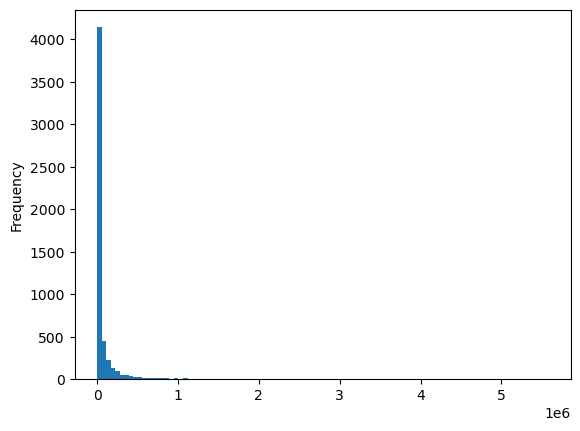

In [15]:
cost_of_fraud['IPInscClaimAmtReimbursed'].plot(kind='hist', bins=100)

<Axes: ylabel='Frequency'>

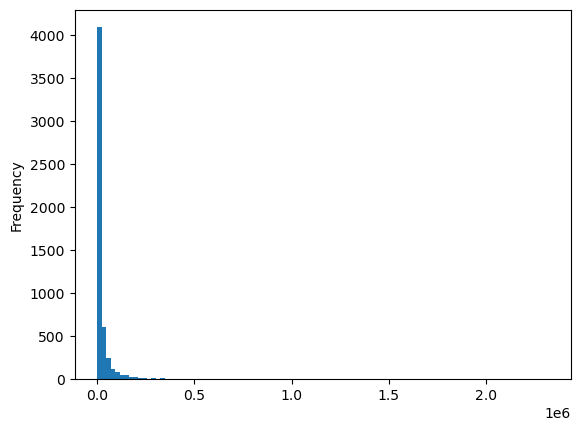

In [16]:
cost_of_fraud['OPInscClaimAmtReimbursed'].plot(kind='hist', bins=100)


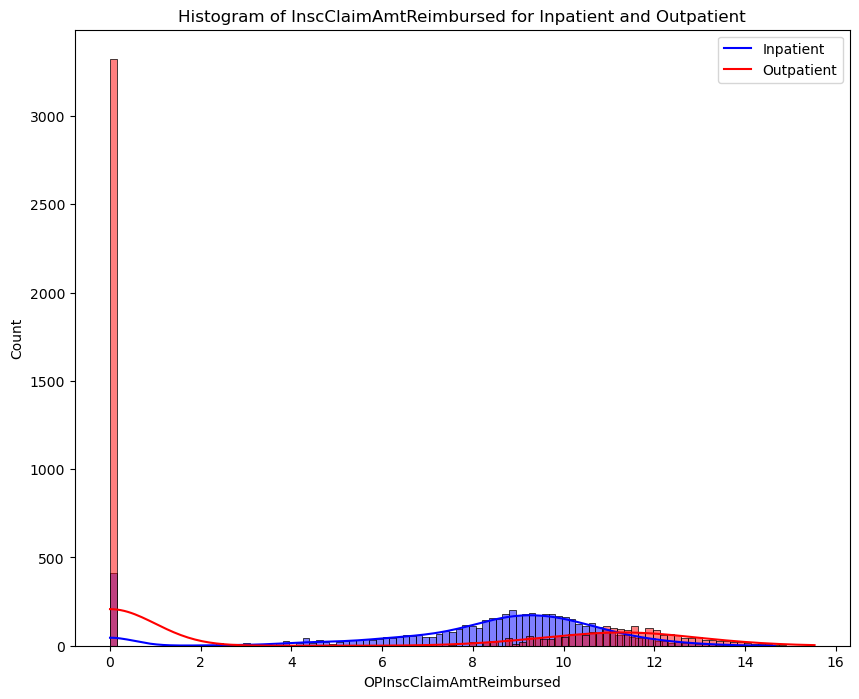

In [17]:
plt.figure(figsize=(10,8))
# cost_of_fraud['OPInscClaimAmtReimbursed'].plot(kind='hist', bins=100)
sns.histplot(np.log1p(cost_of_fraud['OPInscClaimAmtReimbursed']),kde=True, bins=100, color='blue')
sns.histplot(np.log1p(cost_of_fraud['IPInscClaimAmtReimbursed']),kde=True, bins=100, color='red')
plt.title('Histogram of InscClaimAmtReimbursed for Inpatient and Outpatient')
plt.legend(['Inpatient', 'Outpatient'])
plt.show()

# another try

In [18]:
cost_of_fraud

,Provider,IPInscClaimAmtReimbursed,OPInscClaimAmtReimbursed,total_fraud,PotentialFraud
0,PRV51001,97000.0,7640.0,104640.0,No
1,PRV51003,573000.0,32670.0,605670.0,Yes
2,PRV51004,0.0,52170.0,52170.0,No
3,PRV51005,0.0,280910.0,280910.0,Yes
4,PRV51007,19000.0,14710.0,33710.0,No
...,...,...,...,...,...
5405,PRV57759,0.0,10640.0,10640.0,No
5406,PRV57760,0.0,4770.0,4770.0,No
5407,PRV57761,0.0,18470.0,18470.0,No
5408,PRV57762,0.0,1900.0,1900.0,No


<Axes: xlabel='IPInscClaimAmtReimbursed', ylabel='Density'>

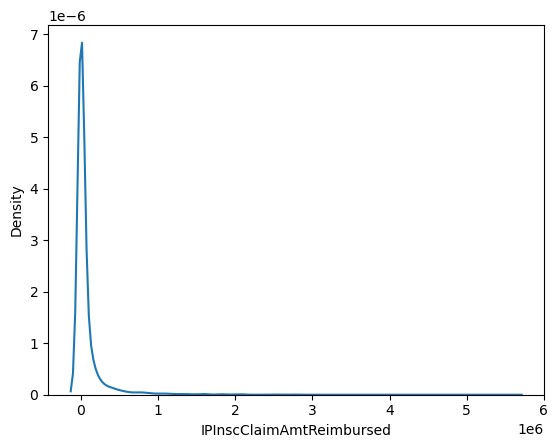

In [19]:
sns.kdeplot(cost_of_fraud['IPInscClaimAmtReimbursed'])

<Axes: xlabel='OPInscClaimAmtReimbursed', ylabel='Density'>

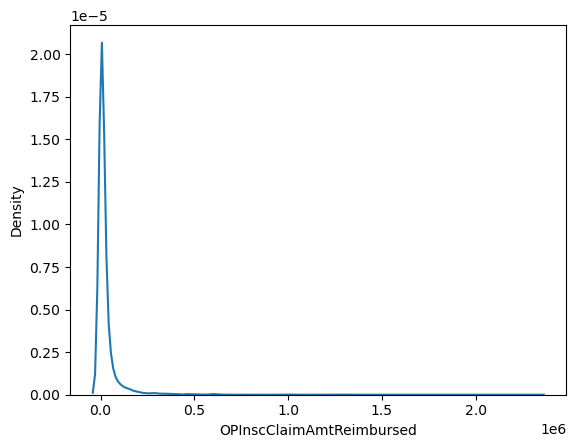

In [20]:
sns.kdeplot(cost_of_fraud['OPInscClaimAmtReimbursed'])


In [21]:
total_cost = cost_of_fraud.groupby('PotentialFraud')['total_fraud'].sum().reset_index()

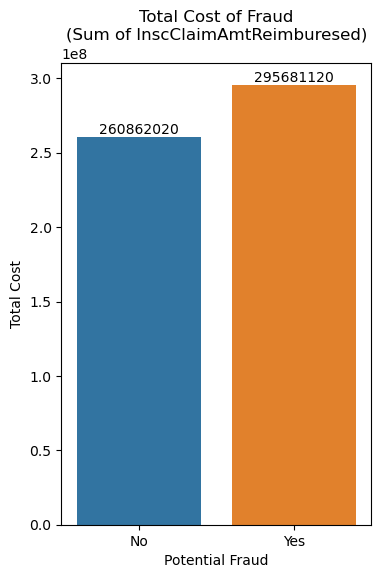

In [22]:
colors = ['lightblue', '#d35400']

plt.figure(figsize=(4,6))
ax = sns.barplot(
    data=total_cost,
    x='PotentialFraud', 
    y='total_fraud', 
    hue=colors,
    legend=False)


# Add labels to bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f',fontsize=10)
    
plt.title('Total Cost of Fraud\n(Sum of InscClaimAmtReimburesed)')
plt.xlabel('Potential Fraud')
plt.ylabel('Total Cost')
plt.show()

In [23]:
total_cost

,PotentialFraud,total_fraud
0,No,260862020.0
1,Yes,295681120.0


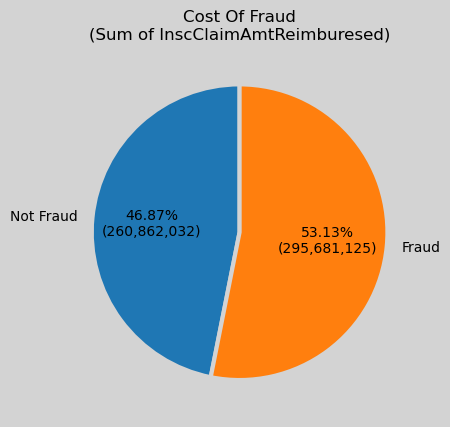

In [24]:
values = total_cost['total_fraud']

fig, ax = plt.subplots()
def make_autopct(values):
    """
    Returns a function that computes both the 
    percentage and the raw value for a pie slice.
    """
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f"{pct:.2f}%\n({val:,})"
    return my_autopct

fig.patch.set_facecolor('lightgray')
ax.set_facecolor('lightgray')
ax.pie(
    values,
    labels=['Not Fraud', 'Fraud'],
    autopct=make_autopct(values),  # custom autopct
    startangle=90,
    wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'lightgray' }
)
plt.title('Cost Of Fraud\n(Sum of InscClaimAmtReimburesed)')
plt.show()

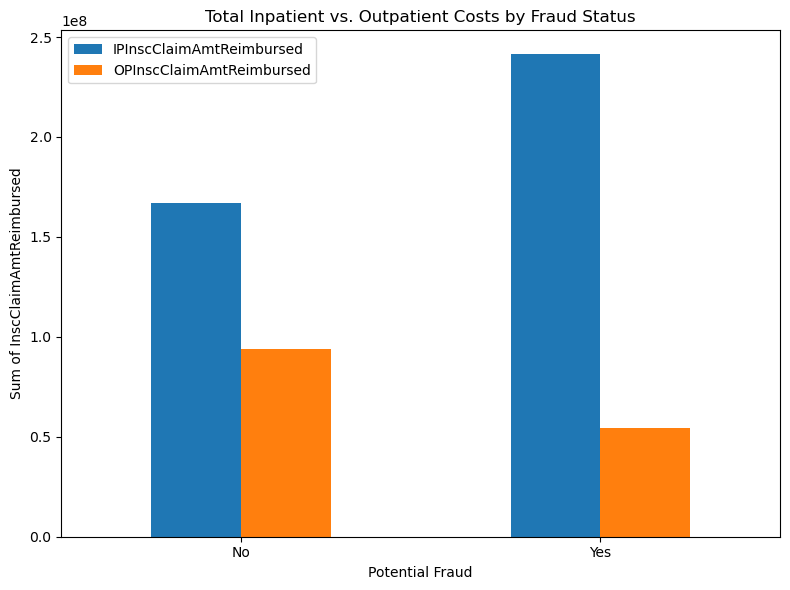

In [25]:
# 1. Group by PotentialFraud and sum
agg_df = cost_of_fraud.groupby('PotentialFraud')[['IPInscClaimAmtReimbursed', 'OPInscClaimAmtReimbursed']].sum()

# 2. Plot as a grouped bar chart
ax = agg_df.plot(kind='bar', figsize=(8, 6))
ax.set_title('Total Inpatient vs. Outpatient Costs by Fraud Status')
ax.set_xlabel('Potential Fraud')
ax.set_ylabel('Sum of InscClaimAmtReimbursed')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.tight_layout()
plt.show()

In [26]:
cost_of_fraud

,Provider,IPInscClaimAmtReimbursed,OPInscClaimAmtReimbursed,total_fraud,PotentialFraud
0,PRV51001,97000.0,7640.0,104640.0,No
1,PRV51003,573000.0,32670.0,605670.0,Yes
2,PRV51004,0.0,52170.0,52170.0,No
3,PRV51005,0.0,280910.0,280910.0,Yes
4,PRV51007,19000.0,14710.0,33710.0,No
...,...,...,...,...,...
5405,PRV57759,0.0,10640.0,10640.0,No
5406,PRV57760,0.0,4770.0,4770.0,No
5407,PRV57761,0.0,18470.0,18470.0,No
5408,PRV57762,0.0,1900.0,1900.0,No


In [27]:
agg_df

,IPInscClaimAmtReimbursed,OPInscClaimAmtReimbursed
PotentialFraud,,
No,167008510.0,93853510.0
Yes,241288510.0,54392610.0


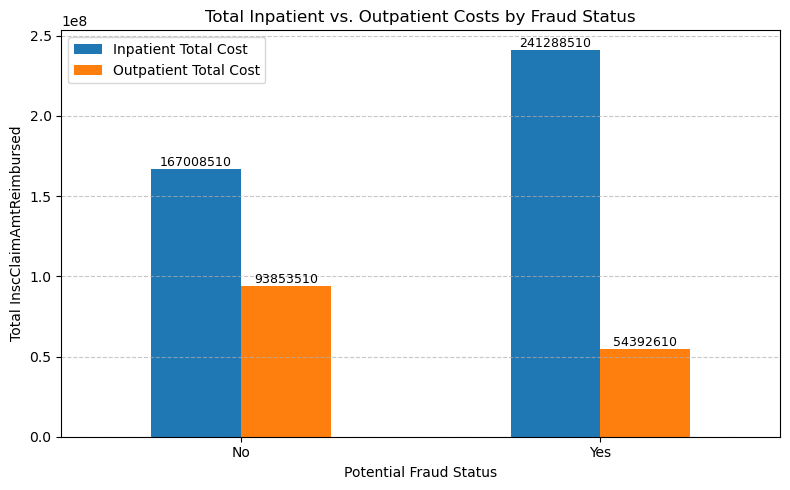

In [28]:
# 1. Group by PotentialFraud and sum
fraud_summary = cost_of_fraud.groupby('PotentialFraud')[['IPInscClaimAmtReimbursed', 'OPInscClaimAmtReimbursed']].sum()


# Create a figure and axes first
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the data on our axes
fraud_summary.plot(
    kind="bar", 
    ax=ax,     # use the axes we created
    rot=0      # no rotation for x-axis labels
)

ax.set_title("Total Inpatient vs. Outpatient Costs by Fraud Status")
ax.set_ylabel("Total InscClaimAmtReimbursed")
ax.set_xlabel("Potential Fraud Status")
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.legend(["Inpatient Total Cost", "Outpatient Total Cost"])

# Loop through each 'bar container' and label them
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=9)  # or '%.1f', etc.

plt.tight_layout()
plt.show()

In [29]:
# cost_of_fraud.to_csv('cost_of_fraud.csv', index=False)

In [58]:
inp = inpatient.groupby('Provider')['InscClaimAmtReimbursed'].sum().reset_index().rename(columns={'InscClaimAmtReimbursed':'IPInscClaimAmtReimbursed'})
inp

,Provider,IPInscClaimAmtReimbursed
0,PRV51001,97000
1,PRV51003,573000
2,PRV51007,19000
3,PRV51008,25000
4,PRV51011,5000
...,...,...
2087,PRV57719,76000
2088,PRV57728,6000
2089,PRV57729,107000
2090,PRV57732,76000


In [59]:
outpa = outpatient.groupby('Provider')['InscClaimAmtReimbursed'].sum().reset_index().rename(columns={'InscClaimAmtReimbursed':'OPInscClaimAmtReimbursed'})
outpa

,Provider,OPInscClaimAmtReimbursed
0,PRV51001,7640
1,PRV51003,32670
2,PRV51004,52170
3,PRV51005,280910
4,PRV51007,14710
...,...,...
5007,PRV57759,10640
5008,PRV57760,4770
5009,PRV57761,18470
5010,PRV57762,1900


In [61]:
df1_outpa = pd.merge(outpa,
         train,
         on='Provider',
         how='left')
df1_outpa

,Provider,OPInscClaimAmtReimbursed,PotentialFraud
0,PRV51001,7640,No
1,PRV51003,32670,Yes
2,PRV51004,52170,No
3,PRV51005,280910,Yes
4,PRV51007,14710,No
...,...,...,...
5007,PRV57759,10640,No
5008,PRV57760,4770,No
5009,PRV57761,18470,No
5010,PRV57762,1900,No


In [62]:
df2_inpa = pd.merge(inp,
         train,
         on='Provider',
         how='left')
df2_inpa

,Provider,IPInscClaimAmtReimbursed,PotentialFraud
0,PRV51001,97000,No
1,PRV51003,573000,Yes
2,PRV51007,19000,No
3,PRV51008,25000,No
4,PRV51011,5000,No
...,...,...,...
2087,PRV57719,76000,No
2088,PRV57728,6000,No
2089,PRV57729,107000,No
2090,PRV57732,76000,No


In [65]:
df3 = pd.merge(df1_outpa,
         df2_inpa,
         on=['Provider','PotentialFraud'],
         how='outer')
df3

,Provider,OPInscClaimAmtReimbursed,PotentialFraud,IPInscClaimAmtReimbursed
0,PRV51001,7640.0,No,97000.0
1,PRV51003,32670.0,Yes,573000.0
2,PRV51004,52170.0,No,NaN
3,PRV51005,280910.0,Yes,NaN
4,PRV51007,14710.0,No,19000.0
...,...,...,...,...
5405,PRV57759,10640.0,No,NaN
5406,PRV57760,4770.0,No,NaN
5407,PRV57761,18470.0,No,NaN
5408,PRV57762,1900.0,No,NaN


In [84]:
motivation = df2_inpa.groupby('PotentialFraud').agg(
    sum_of_reimbursement_amount = ('IPInscClaimAmtReimbursed', 'sum'),
    IPcount_of_providers = ('IPInscClaimAmtReimbursed', 'count'),
)
motivation

,sum_of_reimbursement_amount,IPcount_of_providers
PotentialFraud,,
No,167008510,1652
Yes,241288510,440


In [85]:
motivation2 = df1_outpa.groupby('PotentialFraud').agg(
    sum_of_reimbursement_amount = ('OPInscClaimAmtReimbursed', 'sum'),
    OPcount_of_providers = ('OPInscClaimAmtReimbursed', 'count'),
)
motivation2

,sum_of_reimbursement_amount,OPcount_of_providers
PotentialFraud,,
No,93853510,4550
Yes,54392610,462


,Provider,OPInscClaimAmtReimbursed,PotentialFraud
0,PRV51001,7640,No
1,PRV51003,32670,Yes
2,PRV51004,52170,No
3,PRV51005,280910,Yes
4,PRV51007,14710,No
...,...,...,...
5007,PRV57759,10640,No
5008,PRV57760,4770,No
5009,PRV57761,18470,No
5010,PRV57762,1900,No


<Axes: xlabel='IPcount_of_providers', ylabel='IPsum_of_providers'>

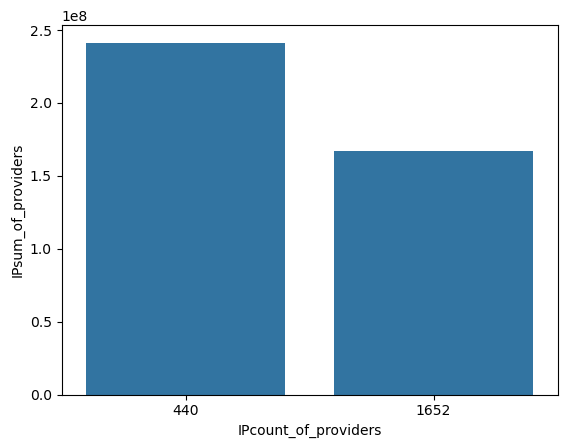

In [75]:
sns.barplot(data=motivation,
            x='IPcount_of_providers',
            y='IPsum_of_providers')

<Axes: xlabel='OPcount_of_providers', ylabel='OPsum_of_providers'>

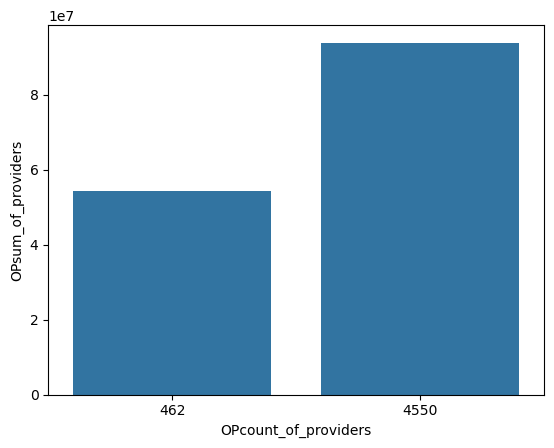

In [76]:
sns.barplot(data=motivation2,
            x='OPcount_of_providers',
            y='OPsum_of_providers')

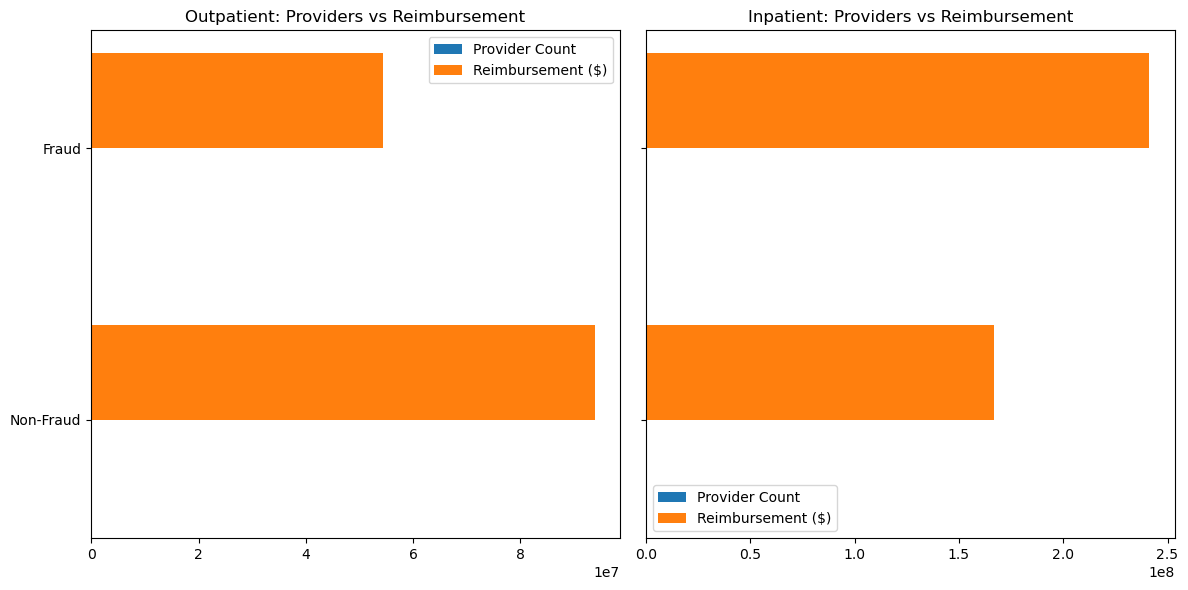

In [79]:
import matplotlib.pyplot as plt

labels = ['Non-Fraud', 'Fraud']
op_money = [93_853_510, 54_392_610]
op_providers = [4550, 462]
ip_money = [167_008_510, 241_288_510]
ip_providers = [1652, 440]

x = np.arange(len(labels))  # positions
width = 0.35

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Outpatient
ax[0].barh(x - width/2, op_providers, height=width, label='Provider Count')
ax[0].barh(x + width/2, op_money, height=width, label='Reimbursement ($)')
ax[0].set_title('Outpatient: Providers vs Reimbursement')
ax[0].set_yticks(x)
ax[0].set_yticklabels(labels)
ax[0].legend()

# Inpatient
ax[1].barh(x - width/2, ip_providers, height=width, label='Provider Count')
ax[1].barh(x + width/2, ip_money, height=width, label='Reimbursement ($)')
ax[1].set_title('Inpatient: Providers vs Reimbursement')
ax[1].set_yticks(x)
ax[1].set_yticklabels(labels)
ax[1].legend()

plt.tight_layout()
plt.show()


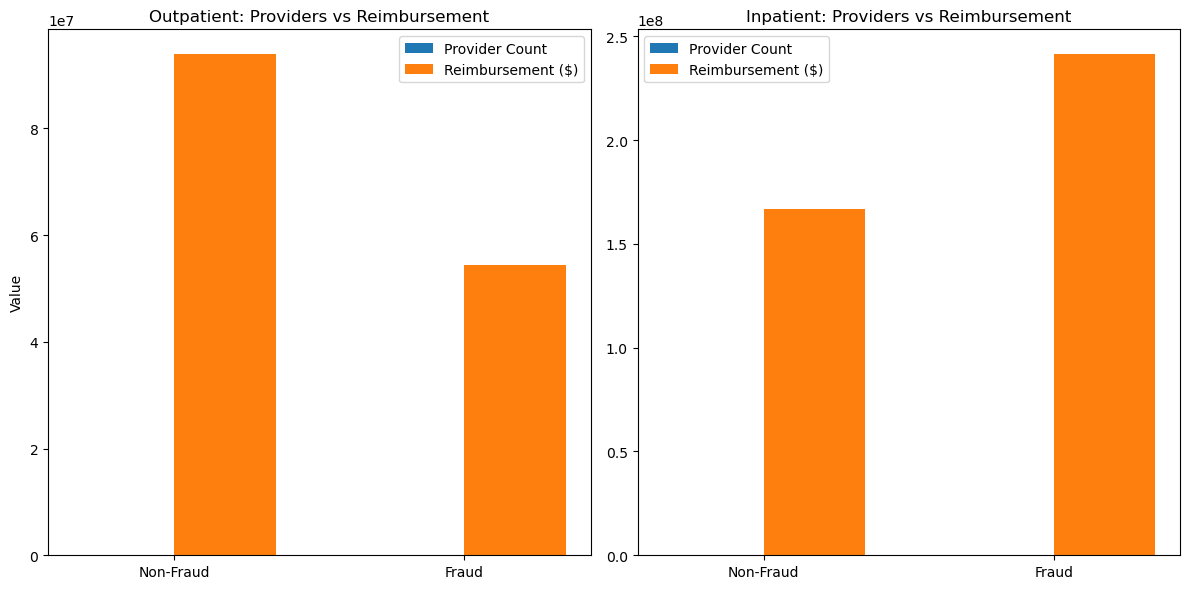

In [80]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Non-Fraud', 'Fraud']

# Outpatient data
op_money = [93853510, 54392610]
op_providers = [4550, 462]

# Inpatient data
ip_money = [167008510, 241288510]
ip_providers = [1652, 440]

x = np.arange(len(labels))  # label positions
width = 0.35  # width of each bar

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Outpatient plot
ax[0].bar(x - width/2, op_providers, width=width, label='Provider Count')
ax[0].bar(x + width/2, op_money, width=width, label='Reimbursement ($)')
ax[0].set_title('Outpatient: Providers vs Reimbursement')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].set_ylabel('Value')
ax[0].legend()

# Inpatient plot
ax[1].bar(x - width/2, ip_providers, width=width, label='Provider Count')
ax[1].bar(x + width/2, ip_money, width=width, label='Reimbursement ($)')
ax[1].set_title('Inpatient: Providers vs Reimbursement')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

plt.tight_layout()
plt.show()


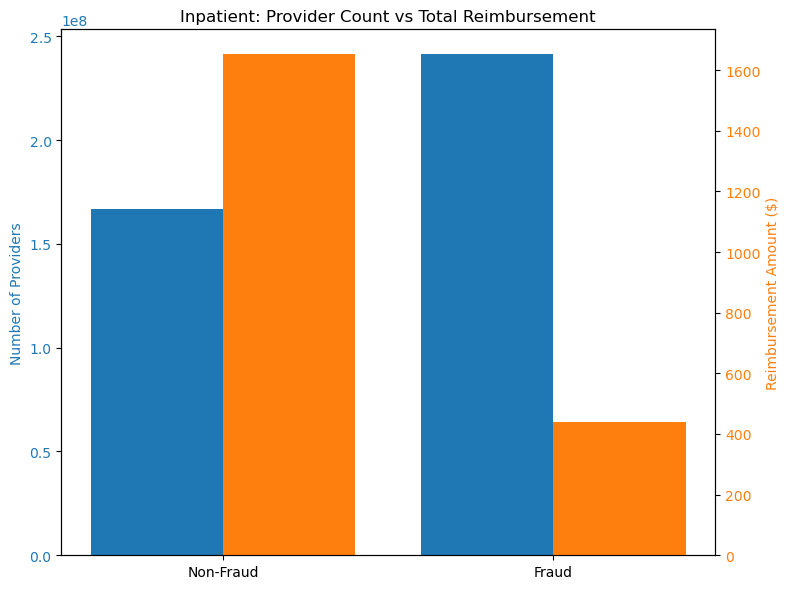

In [82]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Non-Fraud', 'Fraud']
x = np.arange(len(labels))

# Data
ip_providers = motivation['IPsum_of_providers']
ip_money = motivation['IPcount_of_providers']

width = 0.4

fig, ax1 = plt.subplots(figsize=(8, 6))

# First axis: Provider count
ax1.bar(x - width/2, ip_providers, width, label='Provider Count', color='tab:blue')
ax1.set_ylabel('Number of Providers', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Second axis: Reimbursement
ax2 = ax1.twinx()
ax2.bar(x + width/2, ip_money, width, label='Total Reimbursement ($)', color='tab:orange')
ax2.set_ylabel('Reimbursement Amount ($)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# X-axis and title
plt.xticks(x, labels)
plt.title('Inpatient: Provider Count vs Total Reimbursement')
fig.tight_layout()
plt.show()


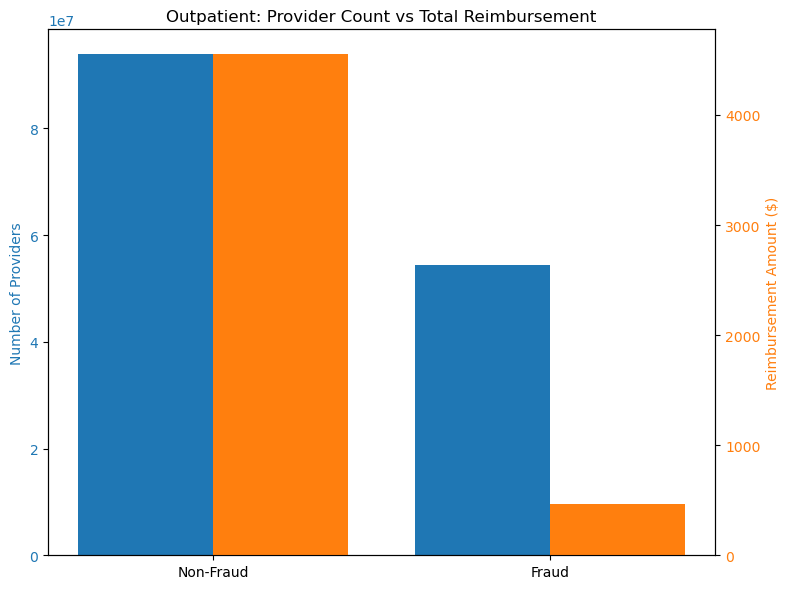

In [83]:
# Plot dual meaning barplot for outpatient reimbursment amount and the count of fraudulent providers.
labels = ['Non-Fraud', 'Fraud']
x = np.arange(len(labels))

# Data
ip_providers = motivation2['OPsum_of_providers']
ip_money = motivation2['OPcount_of_providers']

width = 0.4

fig, ax1 = plt.subplots(figsize=(8, 6))

# First axis: Provider count
ax1.bar(x - width/2, ip_providers, width, label='Provider Count', color='tab:blue')
ax1.set_ylabel('Number of Providers', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Second axis: Reimbursement
ax2 = ax1.twinx()
ax2.bar(x + width/2, ip_money, width, label='Total Reimbursement ($)', color='tab:orange')
ax2.set_ylabel('Reimbursement Amount ($)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# X-axis and title
plt.xticks(x, labels)
plt.title('Outpatient: Provider Count vs Total Reimbursement')
fig.tight_layout()
plt.show()
